# cs224w-colab1 完整流程实现节点嵌入。

1、加载一个经典的网络数据karate club 网络，并探索一些图的属性。
2、导入到PyTorch框架内的Tensor。
3、完成简单的节点嵌入任务。建议自己使用Pytorch实现DeepWalk、node2vec.

# 图基础
我们导入一个经典的karate club网络，进一步进行多种图统计。

### 设置：从networkx直接导入

In [1]:
import networkx as nx

Zachary's Karate club 网络

这个网络是34人的空手道俱乐部社交网络，其中链接表示人之间在俱乐部之外有联系。

In [2]:
G = nx.karate_club_graph()
type(G)

networkx.classes.graph.Graph

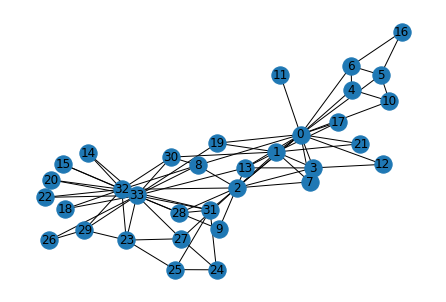

In [3]:
# 观察一下网络结构
nx.draw(G, with_labels = True)

## 问题1： 网络的平均度

In [4]:
def average_degree(num_edges, num_nodes):
    # TODO: 接收边和节点个数，返回图的平均度的函数，四舍五入保留整数。
    avg_degree = 0
    # 实现部分
    avg_degree = 2 * num_edges / num_nodes
    avg_degree = int(avg_degree+0.5)

    return avg_degree
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
f"Average degree is {avg_degree}"

'Average degree is 5'

## 问题2：网络的平均聚集系数？

In [5]:

def average_clustering_coefficient(G):
    # TODO 接收nx.Graph实例，返回平均聚集系数[使用合适的NetworkX工具]，四舍五入保留两位小数
    avg_cluster_coef = 0
    # 实现部分
    avg_cluster_coef = nx.average_clustering(G)
    avg_cluster_coef = quantize_n(avg_cluster_coef)
    ########################
    return avg_cluster_coef
#################################

from decimal import Decimal
def quantize_n(num, index=2):
    # 四舍五入保留小数
    n = 10 ** (-index)
    return Decimal(num).quantize(Decimal(f"{n}"), rounding = "ROUND_HALF_UP")

#################################
avg_cluster_coef = average_clustering_coefficient(G)
f"Average clustering coefficient is {avg_cluster_coef}"

'Average clustering coefficient is 0.57'

## 问题3：节点0的PageRank一次迭代的Pagerank值

利用PageRank的公式$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$完成代码

In [6]:
def one_iter_pagerank(G, beta, r0, node_id):
    # TODO: 接收 nx.Graph, beta, r0， node id，返回r1是一个迭代后的PageRank的值[不使用NetworkX.pagerank工具]，四舍五入的两位小数。
    #! 其中r0是所有节点的初始化PageRank值
    r1 = 0
    # 实现
    r1 += sum([beta * r0/G.degree(node) + (1-beta)/G.number_of_nodes() for node in G.neighbors(node_id)])
    r1 = quantize_n(r1)
    ################################################################
    return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.22


## 问题4：计算节点5的（粗）亲近中心性

亲近中心性的公式：$c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [7]:
def closeness_centrality(G, node=5):
    # TODO: 实现亲近中心性，四舍五入保留两位小数

    closeness = 0

    ## Note:
    ## 1: 可以使用nx.closeness_centrality
    ## 2: 注意返回值是已经归一化的与公式不同。

    #########################################
    # 工具版
    closeness = nx.closeness_centrality(G,node)
    # 公式版
    closeness = 1/sum( nx.single_source_shortest_path(G,node))
    closeness = quantize_n(closeness)
    return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.00


# 图转张量
将图转换为张量

### 设置：检查pytorch是否安装

In [8]:
import torch
torch.__version__

'1.10.0+cu113'

### PyTorch的张量基础
产生全0，全1，全随机值

In [9]:
zeros = torch.zeros(2,3)
zeros

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [10]:
ones = torch.ones(4,3)
ones

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [11]:
rand_tensor = torch.rand(3,4)
rand_tensor

tensor([[0.7126, 0.7076, 0.5125, 0.6441],
        [0.0364, 0.2576, 0.7025, 0.8922],
        [0.1022, 0.0525, 0.7781, 0.2793]])

### Pytorch 张量类型属性

In [12]:
zeros.dtype

torch.float32

In [13]:
# 可以直接修改type
zeros = zeros.type(torch.long)
zeros.dtype

torch.int64

## 问题5：获取karate club网络的边列表，转置存入torch.LongTensor，torch.sum求pos_edge_index张量 

In [14]:
def graph_to_edge_list(G):
    # TODO: 接收网络，返回 list[tuple(node,node)]

    edge_list = []

    ############# 实现代码 ############
    edge_list = [edge for edge in G.edges()]
    #########################################

    return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: 接收边列表，返回张量，张量形状应该是2*边个数

  edge_index = torch.tensor([])

  ############# 实现代码 ############
  edge_index = torch.Tensor(edge_list).type(torch.LongTensor).T
  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## 问题6：请实现下面边的负采样函数，计算哪个（1~5）边可以称为潜在的负采样的边。

In [15]:
import random

def sample_negative_edges(G, num_neg_samples):
    # TODO: 接收网络和负采样个数。
    # ! 无需考虑负采样个数超出图可以提供的情况
    # ! 无需考虑自环作为正采样或者负采样


    neg_edge_list = []

    ############# 实现代码 ############
    nodes = [node for node in G.nodes()]
    while num_neg_samples:
        edge = (random.choice(nodes),random.choice(nodes))
        if G.has_edge(*edge):
            continue
        else:
            neg_edge_list.append(edge)
            num_neg_samples -= 1
        
    #########################################

    return neg_edge_list

# 采样 78个负样例
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# 将负边转换为张量
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# 哪些边可以作为负样例？
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# 实现代码 ############
## Note:
## 1: 输出这5个节点是否可以作为负边
for idx, edge in enumerate([edge_1,edge_2,edge_3,edge_4,edge_5]):
    print(f'node_{idx+1} can not be negative edge' if G.has_edge(*edge) else f'node_{idx+1} can be negative edge')

#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
node_1 can not be negative edge
node_2 can be negative edge
node_3 can not be negative edge
node_4 can not be negative edge
node_5 can be negative edge


# 节点表征
实现第一个学习算法，节点表征模型

### 设置

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.10.0+cu113


需要了解一些nn.Embedding模块，示例如下：

In [17]:
# 初始化一个嵌入层，假定需要嵌入4个项目，每个项目8个维度

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


在嵌入矩阵中使用索引获取需要的项目

In [18]:
# 选择一个项目
id = torch.LongTensor([1])
print(emb_sample(id))


tensor([[-1.0352, -0.4415,  2.2500,  0.5038,  1.0643,  0.0126,  0.1707, -0.3816]],
       grad_fn=<EmbeddingBackward0>)


In [19]:

# 多个项目
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))


tensor([[-1.0352, -0.4415,  2.2500,  0.5038,  1.0643,  0.0126,  0.1707, -0.3816],
        [-1.6077, -1.0590,  0.3499, -1.4417, -0.4615, -1.0412,  1.4964, -0.4299]],
       grad_fn=<EmbeddingBackward0>)


In [20]:

# 获取嵌入权重矩阵的形状
shape = emb_sample.weight.data.shape
print(shape)


torch.Size([4, 8])


In [21]:

# 重写一下权重矩阵
emb_sample.weight.data = torch.ones(shape)

# 观察是否真实的被赋值了
ids = torch.LongTensor([[0, 3],[2,3]])
print(emb_sample(ids))
emb_sample(ids).shape
torch.tensordot(emb_sample(ids)[1],emb_sample(ids)[0])


tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<EmbeddingBackward0>)


tensor(16., grad_fn=<ReshapeAliasBackward0>)

现在，创建一个节点嵌入矩阵
* 节点需要16维度的向量
* 初始化参数为（0，1]的均匀分布，建议使用torch.rand

In [22]:
# 不要修改随机种子
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    # TODO: 接收节点数目，嵌入维度，实现一个节点的嵌入层，保证初始化参数是均匀分布

    emb = None

    ############# 实现代码 ############
    emb = torch.nn.Embedding(num_embeddings=num_node,embedding_dim=embedding_dim)
    emb.weight.data = torch.rand(emb.weight.data.shape)    
    #########################################

    return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

print("Embedding: {}".format(emb))

print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## 可视化初始节点嵌入
可视化嵌入矩阵的好办法是在2D空间可视化，本示例使用PCA降维，然后可视化每个节点的社区信息。

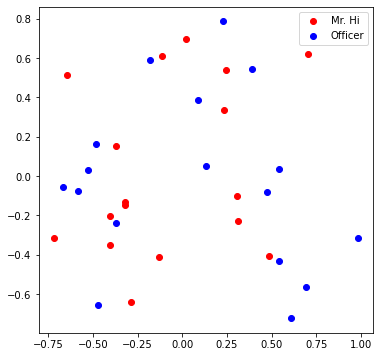

In [23]:
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]['club'] == 'Mr. Hi':
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## 问题7：训练嵌入表征，计算最优损失和精度。

优化嵌入可以分类边是正负样例，给定一个边和每个节点的嵌入表征，节点间点积后接sigmoid可以表示边是正例（>0.5）或者负例（< 0.5）,注意使用了前面的函数，保证之前的答案的正确性。

In [24]:
from torch.optim import SGD
import torch.nn as nn
from sklearn.metrics import accuracy_score

def accuracy(pred, label):
    # TODO 接收预测的张量和事实张量，实现预测精度计算。
    # ! 预测值大于0.5 预测为标签1，否则为0
    # ! 输出精度四舍五入保留4位小数

    accu = 0.0

    ############# 实现代码 ############
    accu = accuracy_score((pred>.5).float(), label)
    accu = quantize_n(accu, index=4)
    #########################################

    return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
    # TODO: 训练你的嵌入层，你可以改变训练次数和学习率，你需要实现
    # 1 获取训练节点的嵌入
    # 2 节点对的点积
    # 3 点积输入到sigmoid函数
    # 4 sigmiod输出到损失函数
    # 5 打印每次训练的损失和精度
    # 6 利用损失和优化器更新嵌入
    # ! 理智观察损失应该训练时越来越小。

    epochs = 500
    learning_rate = .1

    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epochs):

        ############# 实现代码 ############
        # 每次进行操作之前需要禁用梯度操作
        optimizer.zero_grad()
        # 嵌入
        nodes = emb(train_edge)
        # 节点对的点积
        dot_product = torch.sum(nodes[0] * nodes[1],dim=-1)
        # sigmiod
        pred = sigmoid(dot_product)
        loss = loss_fn(pred, train_label)
        accu = accuracy(pred, train_label)
        print(f"epochs:{i+1}, accuracy:{accu}, loss: {loss} ")
        loss.backward()  # 损失回传
        optimizer.step()  # 更新参数
        pass
        #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# 构建正负样本标签
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
train_label = torch.cat([pos_label, neg_label], dim=0)
print(train_label.shape)
# 构建正负样本
# 网络太小，不划分训练集和测试集
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

torch.Size([2, 78])
torch.Size([156])
torch.Size([2, 156])
epochs:1, accuracy:0.5000, loss: 2.0785775184631348 
epochs:2, accuracy:0.5000, loss: 2.0654454231262207 
epochs:3, accuracy:0.5000, loss: 2.0406887531280518 
epochs:4, accuracy:0.5000, loss: 2.0058276653289795 
epochs:5, accuracy:0.5000, loss: 1.9623546600341797 
epochs:6, accuracy:0.5000, loss: 1.911718487739563 
epochs:7, accuracy:0.5000, loss: 1.855301856994629 
epochs:8, accuracy:0.5000, loss: 1.7944073677062988 
epochs:9, accuracy:0.5000, loss: 1.7302517890930176 
epochs:10, accuracy:0.5000, loss: 1.663956880569458 
epochs:11, accuracy:0.5000, loss: 1.596542239189148 
epochs:12, accuracy:0.5000, loss: 1.5289276838302612 
epochs:13, accuracy:0.5000, loss: 1.4619240760803223 
epochs:14, accuracy:0.5000, loss: 1.3962353467941284 
epochs:15, accuracy:0.5000, loss: 1.3324580192565918 
epochs:16, accuracy:0.5000, loss: 1.2710803747177124 
epochs:17, accuracy:0.5000, loss: 1.2124885320663452 
epochs:18, accuracy:0.5000, loss: 1.

## 可视化嵌入结果
与未训练前的对比，也可以作为正确性检查

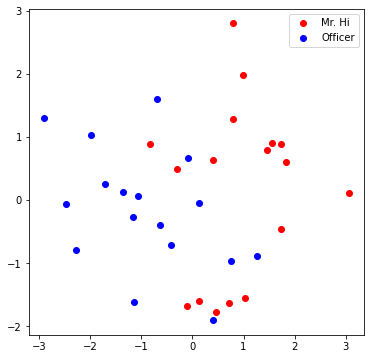

In [25]:
visualize_emb(emb)